In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import zipfile
from io import BytesIO

from kaggle_datasets import KaggleDatasets

#Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation, ZeroPadding2D
from tensorflow.keras.layers import Dropout, GroupNormalization, LeakyReLU, ReLU, Concatenate

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.data import AUTOTUNE



2024-02-14 21:01:56.276508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 21:01:56.276616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 21:01:56.416043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Objective: Transfer Monet's Style to Photographs

Our objective is to train a GAN model to learn the stylistic elements of the artist Monet's works and transfer it to unrelated photographs of everyday life.

### About Cycle GAN

A Cycle GAN is a specialized GAN architecture first introduced by Zhu et. al in their paper "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" which you can find here: https://arxiv.org/abs/1703.10593.

The "cycle" in Cycle Gan refers to the concept of "cycle consistency". Jason Brownlee explains cycle consistency in his article "A Gentle Introduction to CycleGAN for Image Translation" when he writes "\[Cycle Consistency\] is the idea that an image output by the first generator could be used as input to the second generator and the output of the second generator should match the original image." It can be thought of as analagous to language translation wherein a sentence in one language is translated to another target language and then translated back into the original. If the transalation is of high quality then the sentence returned at the end should be nearly identical to the one you start with. 

With a Cycle GAN we use combine two GANs into a single architecture. We can train one Generator to take Monet's paintings as input and attempt to generate real photographs while its discriminator attempts to differentiate between the Generator's output (0) and the real photographs (1). We train the other Generator to take real photographs as input and attempt to generate Monet's paintings as output while its discriminator attempts to differentiate between that Generator's output (0) and monet's paintings. 

We can then add Cycle Consistenty Loss as an additional measure as Brownlee notes: "Cycle consistency loss compares an input photo to the Cycle GAN to the generated photo and calculates the difference between the two, e.g. using the L1 norm or summed absolute difference in pixel values.”

Cycle consistency loss helps the model to better learn the "style" being transferred rather than just reproducing duplications of the input.


Works Cited:

Brownlee, J. (2019, August 16). A gentle introduction to cyclegan for image translation. MachineLearningMastery.com. https://machinelearningmastery.com/what-is-cyclegan/ 

Zhu, Jun-Yan, et al. “Unpaired Image-to-Image Translation Using Cycle-Consistent Adversarial Networks.” 2017 IEEE International Conference on Computer Vision (ICCV), IEEE, 2017. Crossref, https://doi.org/10.1109/iccv.2017.244.


In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH+'/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH+'/photo_tfrec/*.tfrec'))


In [3]:
num_monet = len([file for file in os.listdir('/kaggle/input/gan-getting-started/monet_jpg')])
num_photo = len([file for file in os.listdir('/kaggle/input/gan-getting-started/photo_jpg')])

print(f"There are {num_monet} JPGs of Monet paintings")
print(f"There are {num_photo} JPGS of photographs")

There are 300 JPGs of Monet paintings
There are 7038 JPGS of photographs


## About the Data

Our dataset consists of 300 images of Monet paintings in JPG format and approximately 7,000 photographs also in JPG format. 

All the images in our dataset are 256x256 pixels. 


In [4]:
## Helpful functions to read the TFrecords and decode images throughout this notebook
## are thanks to Amy Jang (https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook)

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    
    #standardize the pixels between -1 and 1
    image = (tf.cast(image, tf.float32) / 127.5) - 1 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

#function to read tfrecord and transform images to standardized tensors
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

We can see examples of both the monet and photograph JPGs below.

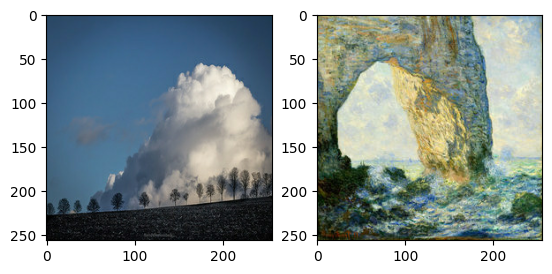

In [8]:
f, axarr = plt.subplots(1,2)

axarr[0].imshow(example_photo[0] * 0.5 + 0.5)

axarr[1].imshow(example_monet[0] * 0.5 + 0.5)

# Building the Cycle GAN

We are going to use U-Net architecture for our GAN Generator. In this architecture, we will have downsampling from the input image followed by a bottleneck of a few skip-connected layers, followed by upsampling until the generator produces an image with the same resolution as the input image. 

You can see an example of the U-Net architecture in a CycleGAN in the paper, "Image-to-Image Translation with Conditional Adversarial Networks" by Isola et. al. A link to the paper is provided here: https://arxiv.org/abs/1611.07004



In [9]:
def encoder(filters, size, norm=True):
    initializer = RandomNormal(mean=0.0, stddev=0.02)
    gamma_init = RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                     kernel_initializer=initializer))
    
    if norm:
        result.add(GroupNormalization(filters,
                                     gamma_initializer=gamma_init))
        
    result.add(LeakyReLU())
    
    return result

In [10]:
def decoder(filters, size, dropout=False):
    initializer = RandomNormal(mean=0.0, stddev=0.02)
    gamma_init = RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer))
    
    result.add(GroupNormalization(filters,
                                 gamma_initializer=gamma_init))
    
    if dropout:
        result.add(Dropout(0.5))
        
    result.add(ReLU())
    
    return result

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    encoder_stack = [
        encoder(64, 4, norm=False), 
        encoder(128, 4),
        encoder(256, 4), 
        encoder(512, 4), 
        encoder(512, 4), 
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4),
    ]

    decoder_stack = [
        decoder(512, 4, dropout=True),
        decoder(512, 4, dropout=True),
        decoder(512, 4, dropout=True),
        decoder(512, 4),
        decoder(256, 4),
        decoder(128, 4),
        decoder(64, 4),
    ]

    initializer = RandomNormal(mean=0.0, stddev=0.02, seed=1404)
    last = Conv2DTranspose(3, 4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh') # (bs, 256, 256, 3)

    result = inputs

    # Encode through the model
    skips = []
    for encode in encoder_stack:
        result = encode(result)
        skips.append(result) #prepare skip connections
        
    # Prepare to concatenate matching resolution layers
    skips = reversed(skips[:-1]) 
    
    #Resnet bottleneck with concatenation
    ##########
    resnet = Conv2D(512, 1, padding='same')(result)
    result = Concatenate()([result, resnet])
    
    resnet = Conv2D(512, 1, padding='same')(result)
    result = Concatenate()([result, resnet])

    # Decode and concatenate skips
    for decode, skip in zip(decoder_stack, skips):
        result = decode(result)
        result = Concatenate()([result, skip])

    result = last(result)

    return Model(inputs=inputs, outputs=result)

In [12]:
def Discriminator():
    
    initializer = RandomNormal(mean=0.0, stddev=0.02, seed=1862)

    inp = Input(shape=[256, 256, 3], name='input_image')

    x = inp

    encode1 = encoder(64, 4, norm=False)(x) # (bs, 128, 128, 64)
    encode2 = encoder(128, 4)(encode1) # (bs, 64, 64, 128)
    encode3 = encoder(256, 4)(encode2) # (bs, 32, 32, 256)

    zero_pad1 = ZeroPadding2D()(encode3) # (bs, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = GroupNormalization(512)(conv)

    leaky_relu = LeakyReLU()(norm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last)

In [13]:
monet_generator = Generator() 
photo_generator = Generator() 

monet_discriminator = Discriminator() 
photo_discriminator = Discriminator()

### Plot architecture of generators

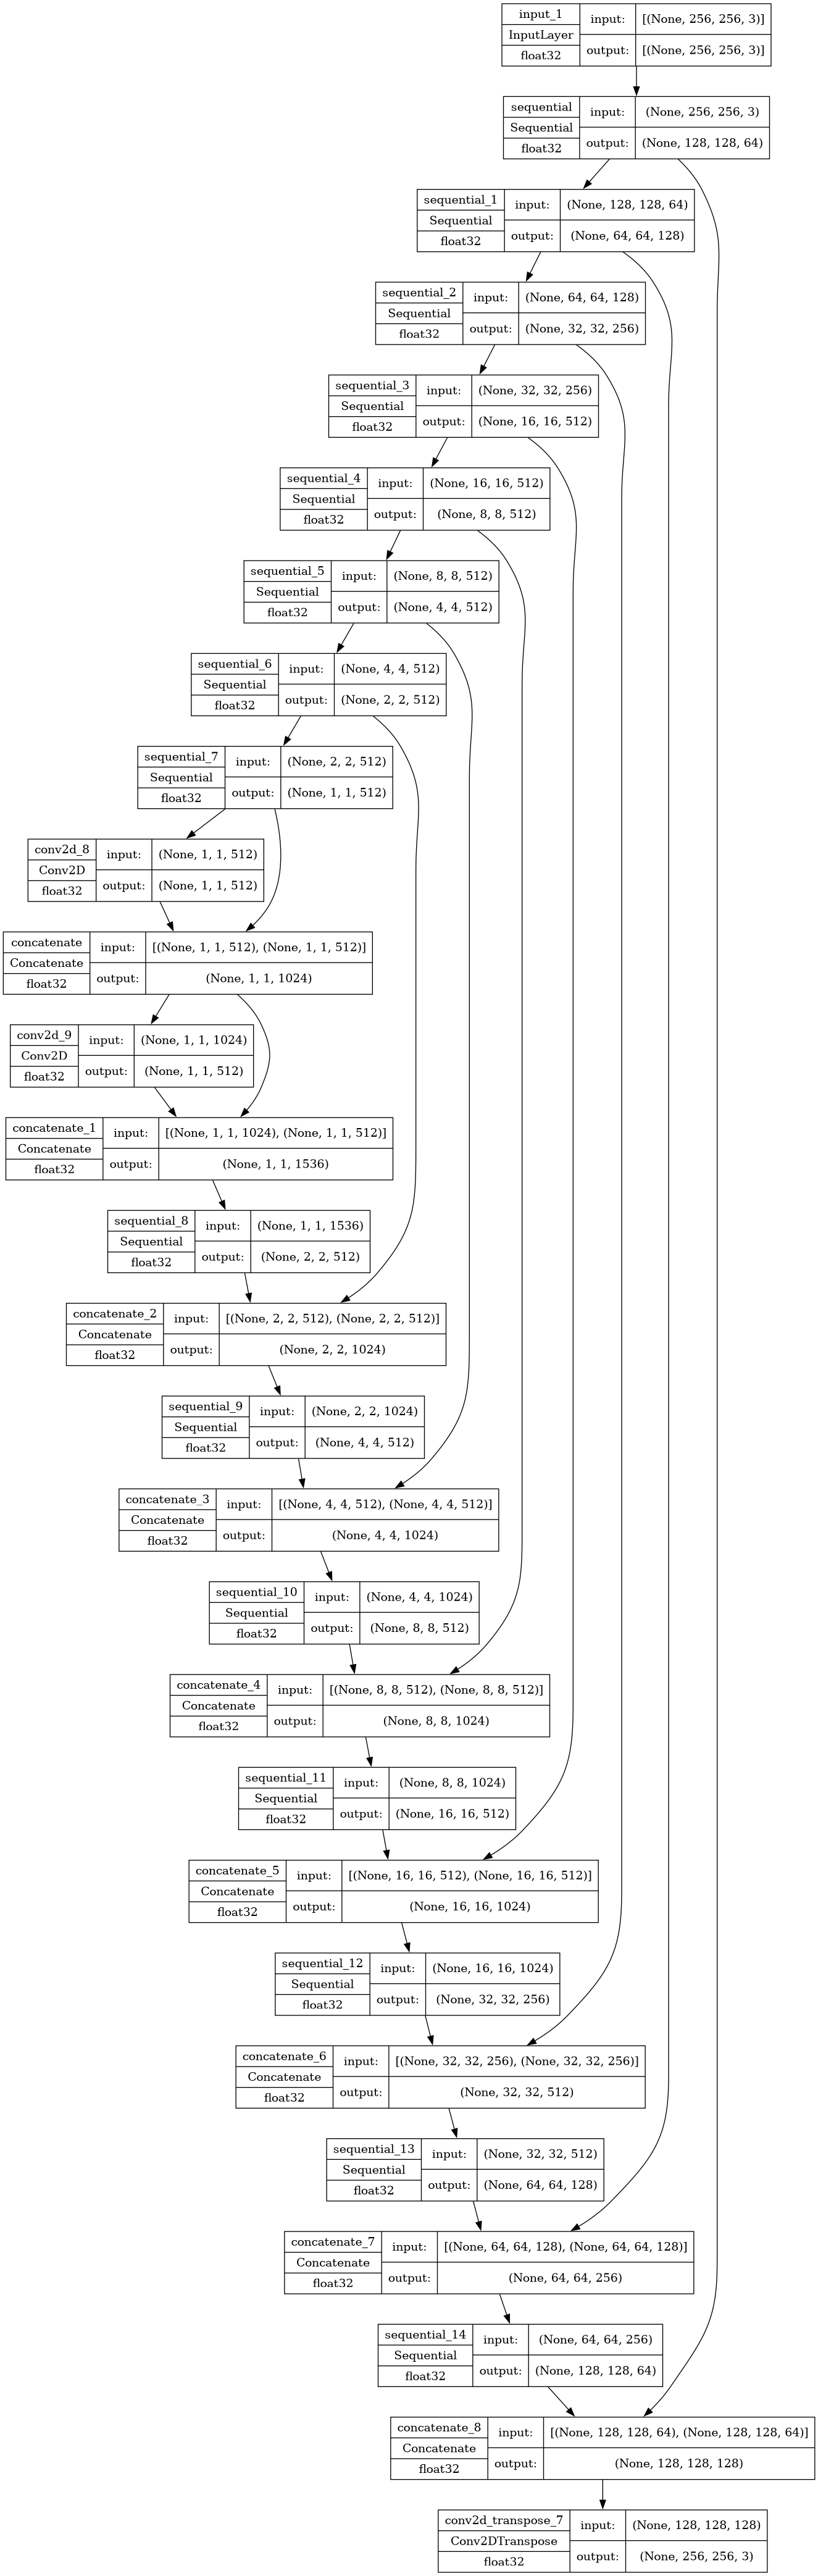

In [14]:
tf.keras.utils.plot_model(monet_generator,
                         show_shapes=True,
                        show_dtype=True,)

### Plot architecture of discriminators

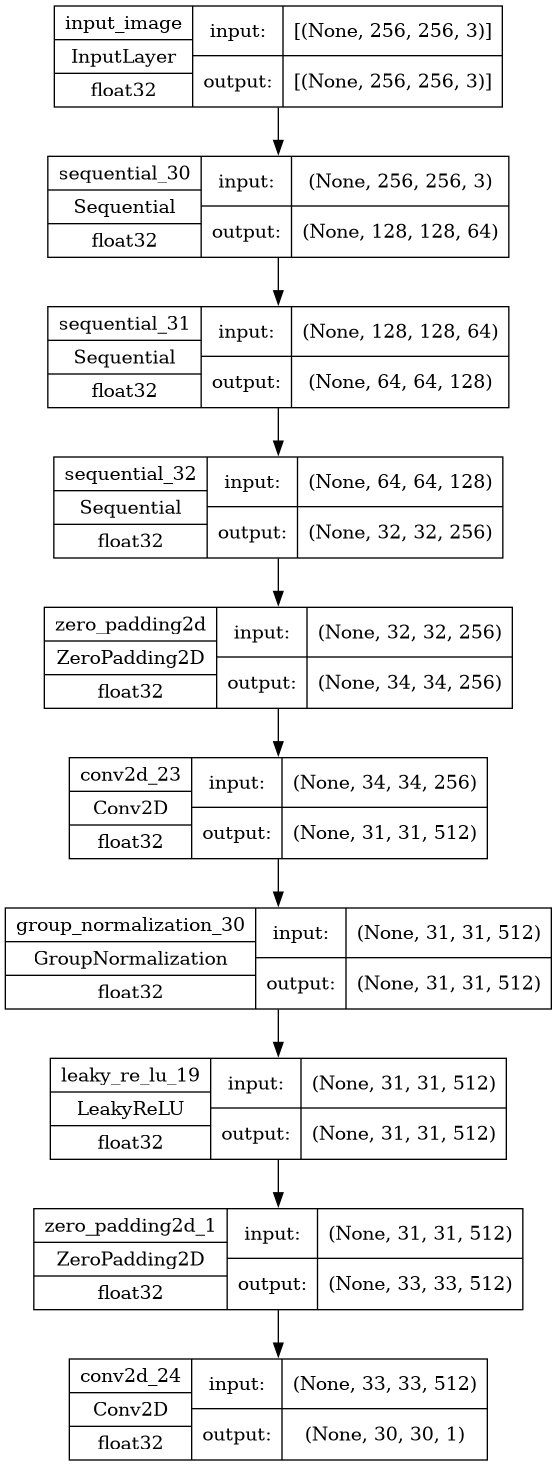

In [15]:
tf.keras.utils.plot_model(monet_discriminator,
                         show_shapes=True,
                        show_dtype=True,)

## Define Loss Functions

In [16]:
def discriminator_loss(real, generated):
        
    real_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)        
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def generator_loss(generated):
    return BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1
    
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss
    
#instantiate optimizers
m_gen_optimizer = tf.keras.optimizers.Adam(.0002)
p_gen_optimizer = tf.keras.optimizers.Adam(.0002)
m_disc_optimizer = tf.keras.optimizers.Adam(.0002)
p_disc_optimizer = tf.keras.optimizers.Adam(.0002)
    

## Create CycleGan Class from Keras Model 

In [17]:
class CycleGan(Model):
    """
    CycleGan class that inherits from keras.Model
    to combine generator and discriminator pairs
    and compile the CycleGan losses: MSE, 
    Identity Loss, and Cycle-Consistency loss.
    Credit to Amy Jang for foundation.
    """
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10,):
        
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,
        gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        """
        Compile CycleGan generators, discriminators, optimizers, and loss functions
        """
        
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)


            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            #generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # cycle consistency loss (monet->monet, real->real)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # combine generator loss, cycle consistency loss, and identity loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [18]:
cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile(
    m_gen_optimizer = m_gen_optimizer,
    p_gen_optimizer = p_gen_optimizer,
    m_disc_optimizer = m_disc_optimizer,
    p_disc_optimizer = p_disc_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

## Fit Model to Training Data

Below we can use the fit method on our cycle_gan_model object to train the model.



In [19]:
NUM_EPOCHS= 150

early_stopping = EarlyStopping(monitor='monet_gen_loss',
                               patience=10)


history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=NUM_EPOCHS,
    #callbacks=[early_stopping]
)


Epoch 1/150


2024-02-14 21:03:19.294151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/sequential_10/dropout_2/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707944613.673245      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 165s 274ms/step - monet_gen_loss: 6.8652 - photo_gen_loss: 7.3633 - monet_disc_loss: 0.4849 - photo_disc_loss: 0.4499
Epoch 2/150
300/300 [==============================] - 81s 268ms/step - monet_gen_loss: 4.2467 - photo_gen_loss: 4.2817 - monet_disc_loss: 0.6523 - photo_disc_loss: 0.6282
Epoch 3/150
300/300 [==============================] - 81s 267ms/step - monet_gen_loss: 4.1465 - photo_gen_loss: 4.1850 - monet_disc_loss: 0.6252 - photo_disc_loss: 0.5925
Epoch 4/150
300/300 [==============================] - 82s 267ms/step - monet_gen_loss: 3.9992 - photo_gen_loss: 4.0408 - monet_disc_loss: 0.6064 - photo_disc_loss: 0.6054
Epoch 5/150
300/300 [==============================] - 81s 267ms/step - monet_gen_loss: 3.9374 - photo_gen_loss: 3.9812 - monet_disc_loss: 0.6205 - photo_disc_loss: 0.5843
Epoch 6/150
300/300 [==============================] - 81s 267ms/step - monet_gen_loss: 3.8490 - photo_gen_loss: 4.0405 - monet_disc_loss: 0.6218 - pho

### Review Loss Between Monet Generator & Discriminator

In [20]:
mean_monet_disc_loss = []

for i in range(NUM_EPOCHS):
    mean_monet_disc_loss.append(np.asarray(history.history['monet_disc_loss'])[i][0].mean())



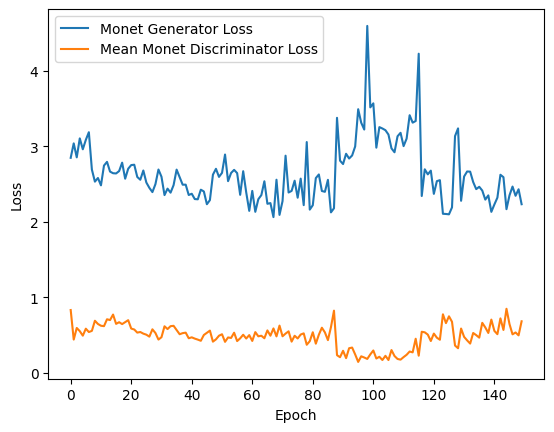

In [21]:
plt.plot(history.history['monet_gen_loss'], label='Monet Generator Loss')
plt.plot(mean_monet_disc_loss, label='Mean Monet Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

After training the model for 150 epochs we can see that, as expected, the Monet generator and Monet discriminator have an inverse relationship with regard to their loss. As the generator's loss decreases the discriminator's loss increases and vice versa. Around epoch 90 the discriminator became more proficient at identifying generated images from real ones and the generator's loss increased dramatically in response. After a few dozen epochs the generator overcomed its deficiency and was able to lower again.

## Conclusions

Using Kaggle's MiFID scores as the main metric for evaluation I found that a resnet bottleneck in U-net architecture of the generator helped improve performance of the CycleGan. Additionally, initializing the gamma parameter by sampling from the normal distribution for the Instance Normalization layers also appeared to help with performance.

The biggest impact on performance, however, was the total time trained. Early on I had used early stopping to deal with potential overfitting (a habit from previous weeks' assignments) and noticed severely degraded performance. This is because I initially misunderstood the nature of loss in a GAN: the loss does not refer to a ground truth but to the performance of the generator with regard to the discriminator (and vice versa.) Once I corrected this by removing the early stopping and let the model train for as long as possible the generated images improved a lot resulting in a difference of about 50 points in the final score. Due to the time limit of the Kaggle competition I kept a ceiling of 150 epochs for this model but it is possible that performance would continue to improve if the model was allowed to train for much longer. 

### Display Sample "Monet-ified" Generated Photos from Model

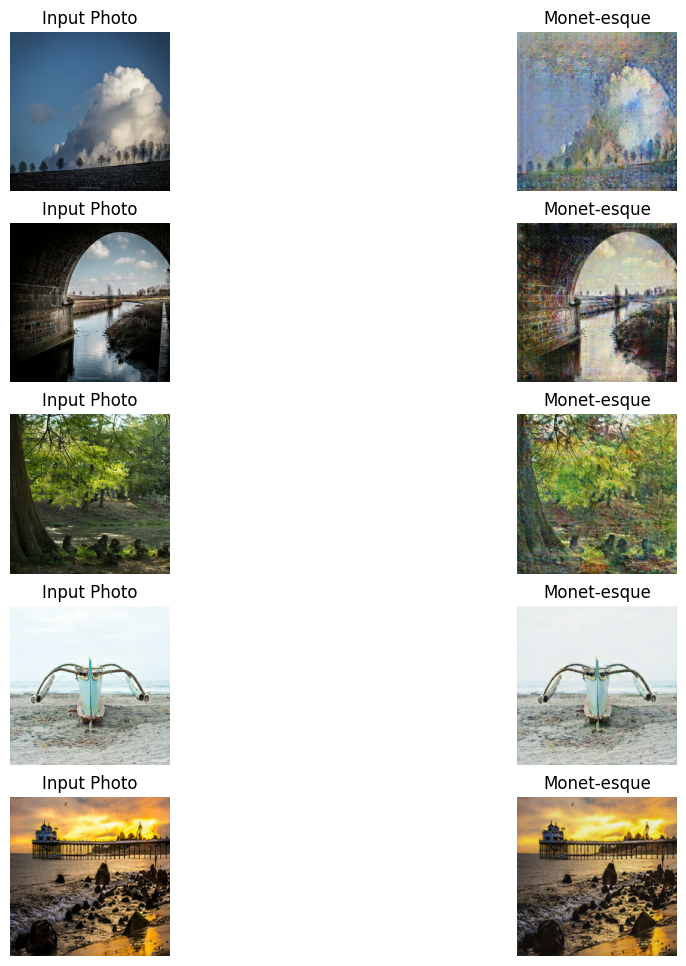

In [22]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8) #transform from standardized
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8) 

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Generate Images for Kaggle Submission

In [23]:
from tensorflow.keras.utils import array_to_img

def generate_and_save(generator, ds):
    """
    Helper function to generate images
    and prepare them for Kaggle submission.
    
    Credit to: ANDREY NESTEROV
    """
    count = 0
    if os.path.exists('images.zip'):
        os.remove('images.zip')
    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for images_batch in ds:
            pred = generator.predict(images_batch, verbose=0)
            pred = np.squeeze((pred * 127.5 + 127.5).astype(np.uint8)) 
            
            count += 1
            if count < 7010:
                generated_image = array_to_img(pred)
                generated_image_bytes = BytesIO()
                generated_image.save(generated_image_bytes, format='JPEG')
                generated_image_bytes.seek(0)
                zipf.writestr(f'generated_image_{count}.jpg', generated_image_bytes.getvalue())
                if count % 1024 == 0:
                    print(f'Archived images: {count}')
            else:
                ##end full loop
                break

In [24]:
generate_and_save(monet_generator, photo_ds)

Archived images: 1024
Archived images: 2048
Archived images: 3072
Archived images: 4096
Archived images: 5120
Archived images: 6144
